# Import necessary libraries

In [1]:
# from eval_on_test import read_data
#https://huggingface.co/docs/transformers/tasks/token_classification

In [2]:
import pandas as pd
import gzip
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, pipeline,  AutoModelForTokenClassification
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from functools import partial
from seqeval.scheme import IOB2

device = "cuda" if torch.cuda.is_available() else "cpu"
device

2024-03-08 19:14:34.356396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:14:34.356477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:14:34.459501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 19:14:34.510771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 19:14:39.644851: W tensorflow/compiler/tf2

'cuda'

In [3]:
id2label = {0: 'O',1: 'I-ORG', 2: 'I-PER', 3: 'I-LOC', 4: 'B-ORG', 5: 'B-PER', 6: 'B-LOC'}
label2id = {v:i for i,v in id2label.items()}
label2id

{'O': 0,
 'I-ORG': 1,
 'I-PER': 2,
 'I-LOC': 3,
 'B-ORG': 4,
 'B-PER': 5,
 'B-LOC': 6}

# Load Data

In [29]:
def read_and_combine_datasets(fpaths):
    """
    Read and combine datasets from given file paths.

    Args:
        fpaths (list of str): List of file paths.

    Returns:
        combined_df (DataFrame): Combined dataset.
    """
    combined_data = []
    for fpath in fpaths:
        with gzip.open(fpath, 'rt', encoding='utf-8') as f:
            _data = [[line.split('\t') for line in block.split('\n') if line.strip()] for block in f.read().split('\n\n')]
            combined_data.extend([([token for token, label in sentence], [label for token, label in sentence]) for sentence in _data])
    return pd.DataFrame(combined_data, columns=["sentence", "label"])

def stratified_split_train_set(train_df, test_size=0.2, random_state=42):
    """
    Perform a stratified split on the training set.

    Args:
        train_df (DataFrame): Training dataset.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    # Stratify by labels to maintain distribution
    strats= list(pd.cut(train_df["sentence"].apply(len), bins=[0, 5, 10, 15, 20, 25, 30, 55, 70, 100],
                                                                    labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-55', '50-80', '80-100']).values)
    return train_test_split(train_df["sentence"], train_df["label"], test_size=test_size, random_state=random_state, stratify=strats)


def analyze_dataset(dataset, labels):
    num_examples = len(dataset)
    num_tokens = sum(len(text) for text in dataset)
    named_entities = dict(Counter(ent for label in labels for ent in label).most_common())
    total_unique_words = len(set(word for sentence in dataset for word in sentence))
    return "Len: "+ str(num_examples),  "Tokens: "+str(num_tokens), "Unique: "+str(total_unique_words), "Entities: "+ str(named_entities)


def combine_and_split_datasets(train_langs=["en", "it", "af", "sw", "de"], data_dir="/fp/projects01/ec30/IN5550/obligatories/2/data"):
    """
    Combine, split datasets based on specified languages, and prepare training and validation sets.

    Args:
        train_langs (list of str): Languages for training data.
        val_langs (list of str): Languages for validation data.
        data_dir (str): Directory where the datasets are stored.

    Returns:
        training_set, X_train, X_test, y_train, y_test, validation_set: Prepared datasets.
    """
    # Combine training datasets
    train_paths = [f"{data_dir}/train-{lang}.tsv.gz" for lang in train_langs]
    training_set = read_and_combine_datasets(train_paths)

    # Stratified split on training set
    _X_train, _X_val, _y_train, _y_val = stratified_split_train_set(training_set)
    print("Train Language(s):", train_langs)
    print("Train Set:", analyze_dataset(_X_train,_y_train ))
    print("Val Set:",  analyze_dataset(_X_val, _y_val))

    return list(_X_train), list(_X_val) , list(_y_train), list(_y_val)

def getTestDatasets(val_langs=["en"], data_dir="/fp/projects01/ec30/IN5550/obligatories/2/data"):
    all_set ={}
    for lang in val_langs:
        val_set = read_and_combine_datasets([f"{data_dir}/dev-{lang}.tsv.gz"])
        _X_test,_y_test  = list(val_set["sentence"]), list(val_set["label"])
        print(f"Test Set({lang}):",  analyze_dataset(_X_test,_y_test))
        all_set[lang] = _X_test,_y_test
    return all_set

In [30]:
class NERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label2id):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = tokenizer.model_max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        word_labels = self.labels[idx]

        tokenized_inputs = self.tokenizer(text, is_split_into_words=True, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt", add_special_tokens=True)

        input_ids = tokenized_inputs['input_ids'].squeeze()
        attention_mask = tokenized_inputs['attention_mask'].squeeze()

        labels = []
        word_ids = tokenized_inputs.word_ids(batch_index=0)  # Get word_ids for the current sequence
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Special tokens
                labels.append(-100)  # PyTorch's convention to ignore these labels during loss calculation
            elif word_idx != previous_word_idx:  # New word
                labels.append(self.label2id[word_labels[word_idx]])
            else:  # Subtoken of the previous word
                labels.append(self.label2id[word_labels[word_idx]])
            previous_word_idx = word_idx

        label_tensor = torch.LongTensor(labels)
        return input_ids, attention_mask, label_tensor

In [31]:
def collate_fn(batch, pad_token_id):
    input_ids, attention_masks, labels = zip(*batch)

    # Pad sequences so they match the longest sequence in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Assuming labels are already tensors. If not, you might need to convert or pad them here
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100) # Use -100 for ignored index in CrossEntropyLoss

    return input_ids_padded.to(device), attention_masks_padded.to(device), labels_padded.to(device)

In [32]:
from seqeval.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

def validate(model, data_loader, evaluate=False,lang="en"):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, atn_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=atn_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            prediction = outputs.logits.argmax(dim=2).cpu().numpy()
            
            cropped_predictions = [pred[1:len(mask) - 1 - mask.flip(dims=[0]).argmax()] for pred, mask in zip(prediction, atn_mask)]
            cropped_true_labels = [true[1:len(mask) - 1 - mask.flip(dims=[0]).argmax()] for true, mask in zip(labels.cpu().numpy(), atn_mask)]

            predictions.extend(cropped_predictions)
            true_labels.extend(cropped_true_labels)

    avg_loss = total_loss / len(data_loader)

    # Convert predictions and true labels to tag sequences
    id2label = {v: k for k, v in label2id.items()}
    pred_tags = [[id2label[tag_id] for tag_id in seq] for seq in predictions]
    true_tags = [[id2label[tag_id] if tag_id in id2label else '-100' for tag_id in seq] for seq in true_labels]
    f1_score_ = f1_score(true_tags, pred_tags)
    if evaluate:
        print(f"LANG [{lang}]: F1-score (Token-level) : {f1_score_:.3f}")
        print(f'Test Loss: {avg_loss} \n Test Evaluation (strict IOB2):')
        print(classification_report(true_tags, pred_tags, zero_division=0, mode='strict', scheme=IOB2, digits=3))
    return avg_loss, true_tags, pred_tags, f1_score_


def plot_loss(train_losses, val_losses, f1_scores):
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='.', label='Val. F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()


def train(model, train_loader, val_loader, epochs=3, lr=5e-5, early_stopping_patience=3, finetune=False):
    model.requires_grad_(finetune)
    model.classifier.requires_grad_(True)
    model.train()
    print("Trainable parameters: ", format(sum(p.numel() for p in model.parameters() if p.requires_grad), ","))

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    train_losses = []
    val_losses = []
    val_f1s =[]
    
    best_val_loss, best_epoch = float('inf'), 0
    epochs_without_improvement = 0
    best_model_state_dict = None

    for epoch in range(epochs):
        total_train_loss = 0

        # Training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
        for batch in progress_bar:
            model.train()
            input_ids, atn_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=atn_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': loss.item()})
        train_losses.append(total_train_loss / len(train_loader))

        # Validation
        val_loss, true_tags, pred_tags, f1_score = validate(model, val_loader)
        val_f1s.append(f1_score)
        val_losses.append(val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train_loss : {loss.item():.4f}, val_loss: {val_loss:.4f}, val_f1: {f1_score:.4f}')
        scheduler.step(val_loss)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss, best_epoch = val_loss, epoch
            epochs_without_improvement = 0
            best_model_state_dict = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch + 1} as validation loss has not decreased for {early_stopping_patience} epochs since epoch-{best_epoch+1}.')
                break

    # Load the best model state
    model.load_state_dict(best_model_state_dict)

    plot_loss(train_losses, val_losses,val_f1s )
    return model

In [33]:
from torch.utils.data import DataLoader
from functools import partial

def train_test(train_langs, val_langs, model_path, epochs=50, lr=1e-5, bs=128, finetune=True, model_max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_path, model_max_length=model_max_length)
    model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(label2id)).to(device)

    X_train, X_val, y_train, y_val = combine_and_split_datasets(train_langs)
    train_loader = DataLoader(NERDataset(X_train, y_train, tokenizer, label2id), batch_size=bs, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
    val_loader = DataLoader(NERDataset(X_val, y_val, tokenizer, label2id), batch_size=bs, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
    model = train(model, train_loader, val_loader, epochs=epochs, lr=lr, finetune=finetune)

    for lang, data in getTestDatasets(val_langs=val_langs).items():
        X_test, y_test = data
        test_loader = DataLoader(NERDataset(X_test, y_test, tokenizer, label2id), batch_size=bs, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
        test_loss, true_tags, pred_tags, _ = validate(model, test_loader, evaluate=True, lang=lang)
# train_test(["en"], ["en", "de"], model_path = "/fp/projects01/ec30/models/xlm-roberta-base/")

# Part 1: Finetuning Multilingual Transformers on English)

## 1A: Different Language Models

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/xlm-roberta-base/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 16000', 'Tokens: 128429', 'Unique: 28681', "Entities: {'O': 65017, 'I-ORG': 18842, 'I-PER': 11628, 'I-LOC': 10530, 'B-ORG': 7623, 'B-LOC': 7536, 'B-PER': 7253}")
Val Set: ('Len: 4000', 'Tokens: 31965', 'Unique: 10319', "Entities: {'O': 16345, 'I-ORG': 4384, 'I-PER': 3070, 'I-LOC': 2647, 'B-PER': 1911, 'B-LOC': 1809, 'B-ORG': 1799}")
Trainable parameters:  277,458,439


Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.5807, val_loss: 0.4420, val_f1: 0.6958


Epoch 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.3698, val_loss: 0.3466, val_f1: 0.7679


Epoch 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.3416, val_loss: 0.3172, val_f1: 0.7881


Epoch 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.3268, val_loss: 0.3051, val_f1: 0.7987


Epoch 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.2112, val_loss: 0.3013, val_f1: 0.8041


Epoch 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.2020, val_loss: 0.2962, val_f1: 0.8051


Epoch 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.2318, val_loss: 0.2958, val_f1: 0.8141


Epoch 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/50, train_loss : 0.2071, val_loss: 0.2902, val_f1: 0.8157


Epoch 9/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/50, train_loss : 0.1165, val_loss: 0.2938, val_f1: 0.8161


Epoch 10/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/50, train_loss : 0.2130, val_loss: 0.2984, val_f1: 0.8176


Epoch 11/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11/50, train_loss : 0.1701, val_loss: 0.3004, val_f1: 0.8225
Early stopping at epoch 11 as validation loss has not decreased for 3 epochs since epoch-8.


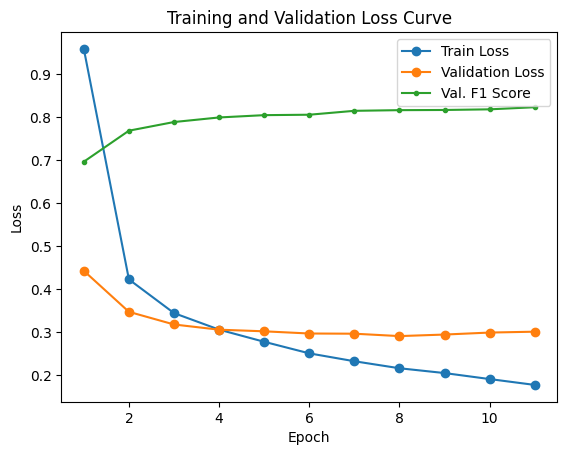

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
LANG [en]: F1-score (Token-level) : 0.821
Test Loss: 0.2951150661027884 
 Test Evaluation (strict IOB2):
              precision    recall  f1-score   support

         LOC      0.855     0.865     0.860      9582
         ORG      0.763     0.734     0.748      7934
         PER      0.871     0.885     0.878      7021

   micro avg      0.831     0.829     0.830     24537
   macro avg      0.830     0.828     0.829     24537
weighted avg      0.830     0.829     0.829     24537



In [9]:
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/xlm-roberta-base/")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 16000', 'Tokens: 128429', 'Unique: 28681', "Entities: {'O': 65017, 'I-ORG': 18842, 'I-PER': 11628, 'I-LOC': 10530, 'B-ORG': 7623, 'B-LOC': 7536, 'B-PER': 7253}")
Val Set: ('Len: 4000', 'Tokens: 31965', 'Unique: 10319', "Entities: {'O': 16345, 'I-ORG': 4384, 'I-PER': 3070, 'I-LOC': 2647, 'B-PER': 1911, 'B-LOC': 1809, 'B-ORG': 1799}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.3781, val_loss: 0.3505, val_f1: 0.7296


Epoch 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.2856, val_loss: 0.2899, val_f1: 0.7945


Epoch 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.2619, val_loss: 0.2799, val_f1: 0.8100


Epoch 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.1730, val_loss: 0.2780, val_f1: 0.8148


Epoch 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.2252, val_loss: 0.2768, val_f1: 0.8271


Epoch 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.1744, val_loss: 0.2802, val_f1: 0.8224


Epoch 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1176, val_loss: 0.2865, val_f1: 0.8219


Epoch 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/50, train_loss : 0.1300, val_loss: 0.2956, val_f1: 0.8232
Early stopping at epoch 8 as validation loss has not decreased for 3 epochs since epoch-5.


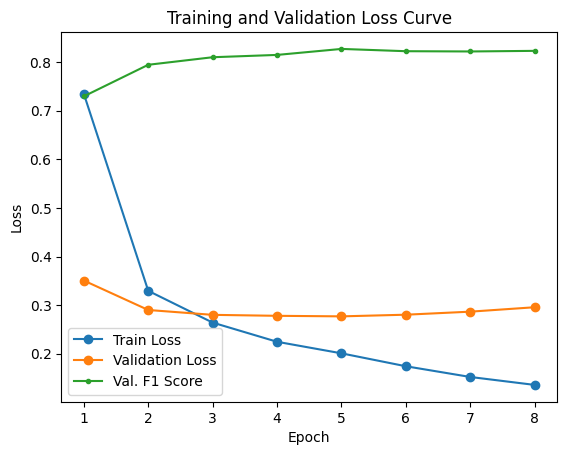

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
LANG [en]: F1-score (Token-level) : 0.828
Test Loss: 0.2893840589478046 
 Test Evaluation (strict IOB2):
              precision    recall  f1-score   support

         LOC      0.860     0.886     0.873      8687
         ORG      0.761     0.725     0.743      7203
         PER      0.888     0.891     0.889      6259

   micro avg      0.837     0.835     0.836     22149
   macro avg      0.836     0.834     0.835     22149
weighted avg      0.836     0.835     0.835     22149



In [10]:
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

In [11]:
#TODO custom model

## 1B: Finetuning and freezing

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 16000', 'Tokens: 128429', 'Unique: 28681', "Entities: {'O': 65017, 'I-ORG': 18842, 'I-PER': 11628, 'I-LOC': 10530, 'B-ORG': 7623, 'B-LOC': 7536, 'B-PER': 7253}")
Val Set: ('Len: 4000', 'Tokens: 31965', 'Unique: 10319', "Entities: {'O': 16345, 'I-ORG': 4384, 'I-PER': 3070, 'I-LOC': 2647, 'B-PER': 1911, 'B-LOC': 1809, 'B-ORG': 1799}")
Trainable parameters:  5,383


Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.7291, val_loss: 0.7169, val_f1: 0.4104


Epoch 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.6556, val_loss: 0.6098, val_f1: 0.4938


Epoch 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.6185, val_loss: 0.5653, val_f1: 0.5294


Epoch 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.6381, val_loss: 0.5414, val_f1: 0.5416


Epoch 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.6397, val_loss: 0.5278, val_f1: 0.5522


Epoch 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.5526, val_loss: 0.5166, val_f1: 0.5616


Epoch 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.5785, val_loss: 0.5092, val_f1: 0.5654


Epoch 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/50, train_loss : 0.5481, val_loss: 0.5023, val_f1: 0.5746


Epoch 9/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/50, train_loss : 0.6130, val_loss: 0.4970, val_f1: 0.5743


Epoch 10/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/50, train_loss : 0.5757, val_loss: 0.4976, val_f1: 0.5732


Epoch 11/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11/50, train_loss : 0.5646, val_loss: 0.4920, val_f1: 0.5780


Epoch 12/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12/50, train_loss : 0.5553, val_loss: 0.4898, val_f1: 0.5778


Epoch 13/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13/50, train_loss : 0.5514, val_loss: 0.4859, val_f1: 0.5819


Epoch 14/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14/50, train_loss : 0.5884, val_loss: 0.4867, val_f1: 0.5809


Epoch 15/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15/50, train_loss : 0.5596, val_loss: 0.4833, val_f1: 0.5840


Epoch 16/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16/50, train_loss : 0.7072, val_loss: 0.4802, val_f1: 0.5841


Epoch 17/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17/50, train_loss : 0.5630, val_loss: 0.4805, val_f1: 0.5802


Epoch 18/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18/50, train_loss : 0.6006, val_loss: 0.4799, val_f1: 0.5861


Epoch 19/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19/50, train_loss : 0.4636, val_loss: 0.4800, val_f1: 0.5839


Epoch 20/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20/50, train_loss : 0.5148, val_loss: 0.4788, val_f1: 0.5887


Epoch 21/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 21/50, train_loss : 0.5433, val_loss: 0.4777, val_f1: 0.5885


Epoch 22/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 22/50, train_loss : 0.6101, val_loss: 0.4785, val_f1: 0.5873


Epoch 23/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 23/50, train_loss : 0.6278, val_loss: 0.4767, val_f1: 0.5863


Epoch 24/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 24/50, train_loss : 0.5208, val_loss: 0.4765, val_f1: 0.5915


Epoch 25/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 25/50, train_loss : 0.5665, val_loss: 0.4744, val_f1: 0.5901


Epoch 26/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 26/50, train_loss : 0.5654, val_loss: 0.4739, val_f1: 0.5886


Epoch 27/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 27/50, train_loss : 0.5191, val_loss: 0.4748, val_f1: 0.5860


Epoch 28/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 28/50, train_loss : 0.6372, val_loss: 0.4736, val_f1: 0.5858


Epoch 29/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 29/50, train_loss : 0.5232, val_loss: 0.4730, val_f1: 0.5888


Epoch 30/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 30/50, train_loss : 0.6914, val_loss: 0.4735, val_f1: 0.5877


Epoch 31/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 31/50, train_loss : 0.5684, val_loss: 0.4729, val_f1: 0.5905


Epoch 32/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 32/50, train_loss : 0.6169, val_loss: 0.4735, val_f1: 0.5861


Epoch 33/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 33/50, train_loss : 0.5768, val_loss: 0.4742, val_f1: 0.5903


Epoch 34/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 34/50, train_loss : 0.5092, val_loss: 0.4766, val_f1: 0.5835
Early stopping at epoch 34 as validation loss has not decreased for 3 epochs since epoch-31.


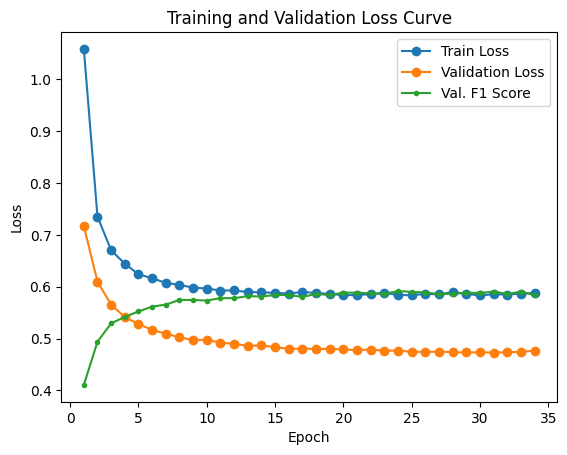

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
LANG [en]: F1-score (Token-level) : 0.584
Test Loss: 0.4940377190897736 
 Test Evaluation (strict IOB2):
              precision    recall  f1-score   support

         LOC      0.665     0.632     0.648      8687
         ORG      0.508     0.408     0.453      7203
         PER      0.753     0.769     0.761      6259

   micro avg      0.648     0.598     0.622     22149
   macro avg      0.642     0.603     0.620     22149
weighted avg      0.639     0.598     0.616     22149



In [12]:
#finetune= False {train classifier only]
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/", finetune=False,  lr=1e-3)

## 1C:  evaluate the finetuned models on the development set in each language (English, Italian, Afrikaans, Swahili, and German).

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 16000', 'Tokens: 128429', 'Unique: 28681', "Entities: {'O': 65017, 'I-ORG': 18842, 'I-PER': 11628, 'I-LOC': 10530, 'B-ORG': 7623, 'B-LOC': 7536, 'B-PER': 7253}")
Val Set: ('Len: 4000', 'Tokens: 31965', 'Unique: 10319', "Entities: {'O': 16345, 'I-ORG': 4384, 'I-PER': 3070, 'I-LOC': 2647, 'B-PER': 1911, 'B-LOC': 1809, 'B-ORG': 1799}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.5266, val_loss: 0.3589, val_f1: 0.7269


Epoch 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.2460, val_loss: 0.2907, val_f1: 0.7994


Epoch 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.2877, val_loss: 0.2798, val_f1: 0.8085


Epoch 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.2255, val_loss: 0.2712, val_f1: 0.8135


Epoch 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.2131, val_loss: 0.2779, val_f1: 0.8177


Epoch 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.1795, val_loss: 0.2807, val_f1: 0.8205


Epoch 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1221, val_loss: 0.2844, val_f1: 0.8202
Early stopping at epoch 7 as validation loss has not decreased for 3 epochs since epoch-4.


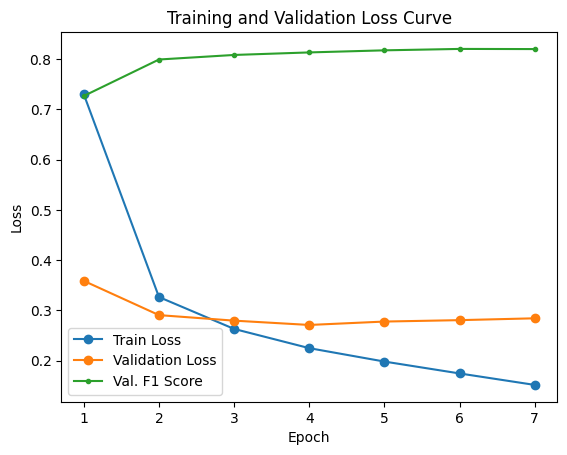

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
Test Set(it): ('Len: 10000', 'Tokens: 80005', 'Unique: 18461', "Entities: {'O': 47357, 'I-ORG': 8992, 'I-PER': 5863, 'B-PER': 4911, 'B-LOC': 4600, 'I-LOC': 4166, 'B-ORG': 4116}")
Test Set(af): ('Len: 1000', 'Tokens: 10894', 'Unique: 3404', "Entities: {'O': 7764, 'I-ORG': 911, 'B-ORG': 583, 'I-PER': 548, 'B-LOC': 529, 'B-PER': 370, 'I-LOC': 189}")
Test Set(sw): ('Len: 1000', 'Tokens: 5609', 'Unique: 1830', "Entities: {'O': 2412, 'I-ORG': 696, 'I-PER': 674, 'I-LOC': 618, 'B-LOC': 452, 'B-PER': 403, 'B-ORG': 354}")
Test Set(de): ('Len: 10000', 'Tokens: 97805', 'Unique: 23570', "Entities: {'O': 69057, 'I-PER': 6539, 'I-ORG': 6107, 'B-LOC': 4968, 'B-PER': 4569, 'B-ORG': 4281, 'I-LOC': 2284}")
LANG [en]: F1-score (Token-level) : 0.828
Test Loss: 0.2819358216056341 
 Test Evaluation (strict IOB2):
              prec

In [13]:
train_test(["en"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

# Part 2: Finetuning Multilingual Transformers on Mixture of Languages 

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en', 'it']
Train Set: ('Len: 32000', 'Tokens: 258292', 'Unique: 49280', "Entities: {'O': 142420, 'I-ORG': 32565, 'I-PER': 21131, 'I-LOC': 17734, 'B-LOC': 15401, 'B-PER': 15132, 'B-ORG': 13909}")
Val Set: ('Len: 8000', 'Tokens: 64589', 'Unique: 18388', "Entities: {'O': 35710, 'I-ORG': 8184, 'I-PER': 5299, 'I-LOC': 4244, 'B-PER': 3798, 'B-LOC': 3796, 'B-ORG': 3558}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.3403, val_loss: 0.2614, val_f1: 0.8085


Epoch 2/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.1827, val_loss: 0.2218, val_f1: 0.8393


Epoch 3/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.1610, val_loss: 0.2192, val_f1: 0.8503


Epoch 4/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.1805, val_loss: 0.2106, val_f1: 0.8564


Epoch 5/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.1378, val_loss: 0.2227, val_f1: 0.8534


Epoch 6/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.0567, val_loss: 0.2226, val_f1: 0.8633


Epoch 7/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1336, val_loss: 0.2252, val_f1: 0.8631
Early stopping at epoch 7 as validation loss has not decreased for 3 epochs since epoch-4.


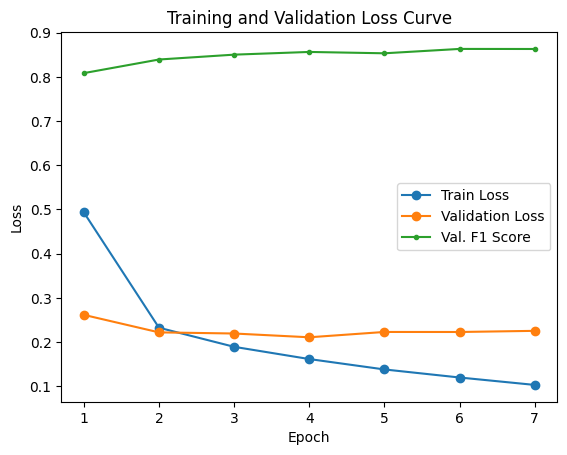

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
Test Set(it): ('Len: 10000', 'Tokens: 80005', 'Unique: 18461', "Entities: {'O': 47357, 'I-ORG': 8992, 'I-PER': 5863, 'B-PER': 4911, 'B-LOC': 4600, 'I-LOC': 4166, 'B-ORG': 4116}")
Test Set(af): ('Len: 1000', 'Tokens: 10894', 'Unique: 3404', "Entities: {'O': 7764, 'I-ORG': 911, 'B-ORG': 583, 'I-PER': 548, 'B-LOC': 529, 'B-PER': 370, 'I-LOC': 189}")
Test Set(sw): ('Len: 1000', 'Tokens: 5609', 'Unique: 1830', "Entities: {'O': 2412, 'I-ORG': 696, 'I-PER': 674, 'I-LOC': 618, 'B-LOC': 452, 'B-PER': 403, 'B-ORG': 354}")
Test Set(de): ('Len: 10000', 'Tokens: 97805', 'Unique: 23570', "Entities: {'O': 69057, 'I-PER': 6539, 'I-ORG': 6107, 'B-LOC': 4968, 'B-PER': 4569, 'B-ORG': 4281, 'I-LOC': 2284}")
LANG [en]: F1-score (Token-level) : 0.836
Test Loss: 0.28844336486315425 
 Test Evaluation (strict IOB2):
              pre

In [14]:
train_test(["en",  "it"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en', 'de']
Train Set: ('Len: 32000', 'Tokens: 284404', 'Unique: 56417', "Entities: {'O': 174868, 'I-ORG': 28295, 'I-PER': 22468, 'B-LOC': 15269, 'B-PER': 14763, 'I-LOC': 14415, 'B-ORG': 14326}")
Val Set: ('Len: 8000', 'Tokens: 71377', 'Unique: 20823', "Entities: {'O': 44029, 'I-ORG': 7177, 'I-PER': 5560, 'B-LOC': 3854, 'B-PER': 3691, 'B-ORG': 3671, 'I-LOC': 3395}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.2790, val_loss: 0.2559, val_f1: 0.7895


Epoch 2/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.1995, val_loss: 0.2252, val_f1: 0.8127


Epoch 3/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.1820, val_loss: 0.2142, val_f1: 0.8314


Epoch 4/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.1355, val_loss: 0.2088, val_f1: 0.8363


Epoch 5/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.1644, val_loss: 0.2117, val_f1: 0.8445


Epoch 6/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.1303, val_loss: 0.2169, val_f1: 0.8456


Epoch 7/50:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1036, val_loss: 0.2250, val_f1: 0.8448
Early stopping at epoch 7 as validation loss has not decreased for 3 epochs since epoch-4.


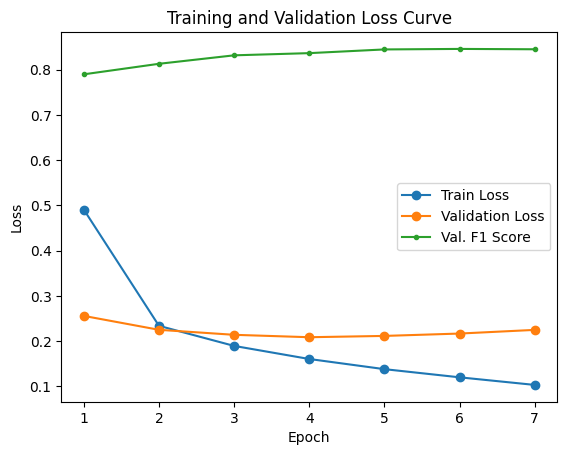

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
Test Set(it): ('Len: 10000', 'Tokens: 80005', 'Unique: 18461', "Entities: {'O': 47357, 'I-ORG': 8992, 'I-PER': 5863, 'B-PER': 4911, 'B-LOC': 4600, 'I-LOC': 4166, 'B-ORG': 4116}")
Test Set(af): ('Len: 1000', 'Tokens: 10894', 'Unique: 3404', "Entities: {'O': 7764, 'I-ORG': 911, 'B-ORG': 583, 'I-PER': 548, 'B-LOC': 529, 'B-PER': 370, 'I-LOC': 189}")
Test Set(sw): ('Len: 1000', 'Tokens: 5609', 'Unique: 1830', "Entities: {'O': 2412, 'I-ORG': 696, 'I-PER': 674, 'I-LOC': 618, 'B-LOC': 452, 'B-PER': 403, 'B-ORG': 354}")
Test Set(de): ('Len: 10000', 'Tokens: 97805', 'Unique: 23570', "Entities: {'O': 69057, 'I-PER': 6539, 'I-ORG': 6107, 'B-LOC': 4968, 'B-PER': 4569, 'B-ORG': 4281, 'I-LOC': 2284}")
LANG [en]: F1-score (Token-level) : 0.835
Test Loss: 0.2865803436010699 
 Test Evaluation (strict IOB2):
              prec

In [34]:
train_test(["en",  "de"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en', 'it', 'de']
Train Set: ('Len: 48000', 'Tokens: 414625', 'Unique: 75401', "Entities: {'O': 252626, 'I-ORG': 42480, 'I-PER': 31735, 'B-LOC': 23148, 'B-PER': 22564, 'I-LOC': 21232, 'B-ORG': 20840}")
Val Set: ('Len: 12000', 'Tokens: 103643', 'Unique: 28396', "Entities: {'O': 63039, 'I-ORG': 10515, 'I-PER': 8025, 'B-LOC': 5827, 'B-PER': 5656, 'I-LOC': 5379, 'B-ORG': 5202}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.1814, val_loss: 0.2174, val_f1: 0.8239


Epoch 2/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.2729, val_loss: 0.1884, val_f1: 0.8463


Epoch 3/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.1538, val_loss: 0.1831, val_f1: 0.8552


Epoch 4/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.1169, val_loss: 0.1829, val_f1: 0.8572


Epoch 5/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.1134, val_loss: 0.1849, val_f1: 0.8609


Epoch 6/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.1018, val_loss: 0.1871, val_f1: 0.8660


Epoch 7/50:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.0726, val_loss: 0.1941, val_f1: 0.8686
Early stopping at epoch 7 as validation loss has not decreased for 3 epochs since epoch-4.


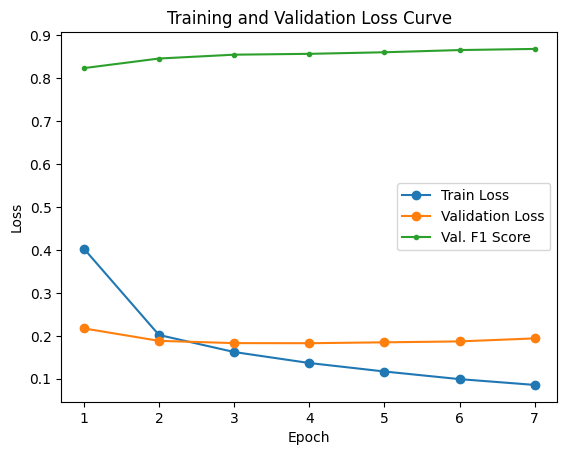

Test Set(en): ('Len: 10000', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
Test Set(it): ('Len: 10000', 'Tokens: 80005', 'Unique: 18461', "Entities: {'O': 47357, 'I-ORG': 8992, 'I-PER': 5863, 'B-PER': 4911, 'B-LOC': 4600, 'I-LOC': 4166, 'B-ORG': 4116}")
Test Set(af): ('Len: 1000', 'Tokens: 10894', 'Unique: 3404', "Entities: {'O': 7764, 'I-ORG': 911, 'B-ORG': 583, 'I-PER': 548, 'B-LOC': 529, 'B-PER': 370, 'I-LOC': 189}")
Test Set(sw): ('Len: 1000', 'Tokens: 5609', 'Unique: 1830', "Entities: {'O': 2412, 'I-ORG': 696, 'I-PER': 674, 'I-LOC': 618, 'B-LOC': 452, 'B-PER': 403, 'B-ORG': 354}")
Test Set(de): ('Len: 10000', 'Tokens: 97805', 'Unique: 23570', "Entities: {'O': 69057, 'I-PER': 6539, 'I-ORG': 6107, 'B-LOC': 4968, 'B-PER': 4569, 'B-ORG': 4281, 'I-LOC': 2284}")
LANG [en]: F1-score (Token-level) : 0.839
Test Loss: 0.28576329180711435 
 Test Evaluation (strict IOB2):
              pre

In [35]:
train_test(["en", "it", "de"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

# Part 3: A Surprise Language 